In [1]:
# first version of radial profile code
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.io as sio
import numpy as np
import sys as sys
mat_contents = sio.loadmat('onehund.mat') 
lfp = mat_contents["onehund"]
csdx = np.array([[0.003130],[0.003169],[0.004244],[0.003107],[0.004100],[0.005167],[0.002875],[0.003953],[0.004989],[0.006077],[0.003860],[0.004917],[0.005932],[0.004772],[0.005860],[0.005582]])
csdy = np.array([[0.002755],[0.003659],[0.002939],[0.004602],[0.003788],[0.002985],[0.005545],[0.004720],[0.003826],[0.003106],[0.005748],[0.004769],[0.003956],[0.005831],[0.004815],[0.005748]])
print(np.shape(csdx))
print("min x: ",np.min(csdx))
print("max x: ",np.max(csdx))
print("min y: ",np.min(csdy))
print("max y: ",np.max(csdy))
csd_x = np.flipud(csdx)
csd_y = np.flipud(csdy)
csd_at = np.hstack((csd_x,csd_y))
t_max = 0

(16, 1)
min x:  0.002875
max x:  0.006077
min y:  0.002755
max y:  0.005831


In [2]:
from scipy.interpolate import griddata
start = 0 #1280 #6030; #6030; #4981 #5980 #11500 #5990 #6010;
end = lfp.shape[1];
print(end)
dt = 0.003;
#n = end-start+1
n=lfp.shape[1]-1 #299 #100; #999;  #10;
lfp1=np.reshape(lfp[:,start],(-1,1))
grid_x, grid_y = np.mgrid[0.0031:0.0055:100j,                                                                                                                                                           
                  0.0031:0.0055:100j]

grid_z = griddata(csd_at, lfp1, (grid_x,grid_y),method='cubic') 
for x in range(n):  
    lfp1=np.reshape(lfp[:,start+1+x],(-1,1))  # start+1 because grid_z(:,:,0) already created  
    grid_z = np.dstack((grid_z,griddata(csd_at, lfp1, (grid_x,grid_y),method='cubic'))) #"cubic")))
    t_max_tmp = np.nanmax(np.abs(grid_z[:,:,x]))
    if t_max_tmp > t_max:
        t_max=t_max_tmp
print(t_max)
print(np.shape(grid_x))
print(np.shape(grid_y))
print(np.shape(grid_z))

136
1889.964524394898
(100, 100)
(100, 100)
(100, 100, 136)


In [3]:
cx = (int) (grid_z.shape[0]/2)
cy = (int) (grid_z.shape[1]/2)

In [4]:
import math
import copy
import scipy.signal as scp
lfpmaxangle = []
lfpminangle = []
lfpmaxval = []
lfpminval = [] 
lfpradprof = []
for num in range(n):
    #Normalization
    img = copy.deepcopy(grid_z[:,:,num])
    for x in range(grid_z.shape[0]):
        for y in range(grid_z.shape[1]):
            if((x-cx)*(x-cx)+(y-cy)*(y-cy)>2500):
                img[x,y] = 0;
    f = np.fft.fft2(img)
    
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20*np.log(np.abs(fshift))
    img = np.rot90(img)
    f_ishift = np.fft.ifftshift(fshift)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)
    img_b = np.rot90(img_back)
    radii = []
    sumradii1 = []
    sumradii2 = []
    for r in range(360):
        width = magnitude_spectrum.shape[0]
        height = magnitude_spectrum.shape[1]
        theta = 2 * math.pi * r / 360;
        dx = (math.cos(theta));
        dy = (math.sin(theta));
        w2 = width * width / 4;
        h2 = height * height / 4;
        m = math.sqrt(w2 * h2 / (dx * dx * h2 + dy * dy * w2));
        x = (cx + m * dx);
        y = (cy + m * dy);
        distance = math.sqrt((x-cx)*(x-cx)+(y-cy)*(y-cy))
        nr = 20;
        radialsum1 = 0;
        radialsum2 = 0;
        for s in range(1,nr):
            sx = (int)(cx + s*distance/nr*dx)
            sy = (int)(cy + s*distance/nr*dy)
            if (~np.isnan(grid_z[sx,sy,num])): 
                radialsum1 = radialsum1 + grid_z[sx,sy,num];
                radialsum2 = radialsum2 + magnitude_spectrum[sx,sy];
        radii.append(r);
        sumradii1.append(radialsum1);
        sumradii2.append(radialsum2);
    filtsumrad2 = scp.savgol_filter(sumradii2, 53, 3) #FFT Magnitude Spectrum Filtered
    lfpmaxangle.append(radii[np.argmax(sumradii1)])
    lfpminangle.append(radii[np.argmin(sumradii1)])
    lfpmaxval.append(np.max(sumradii1))
    lfpminval.append(np.min(sumradii1))
    lfpradprof.append(sumradii1)

In [5]:
# Convert lists to array
lfpmaxangle = np.asarray(lfpmaxangle)
lfpminangle = np.asarray(lfpminangle)
lfpmaxval = np.asarray(lfpmaxval)
lfpminval = np.asarray(lfpminval)
lfpradprof = np.asarray(lfpradprof)

In [6]:
# Correlation of Correlations 
#(i.e. correlation coef for if pre correlation high then is post correlation high)
corrind = []
corrind2 = []
for num in np.arange(n):
    for num2 in np.arange(num+1,n):
        if(num%2==0 and num2%2==0 and num<134 and num2<134 and len(corrind) < 1176):
            corrind.append(np.corrcoef(lfpradprof[num], lfpradprof[num2])[0, 1])
        elif(num%2==1 and num2%2==1):
            corrind2.append(np.corrcoef(lfpradprof[num], lfpradprof[num2])[0, 1])

In [9]:
# Correlation Heatmap
corrind = []
corrind2 = []
for num in np.arange(n):
    for num2 in np.arange(n):
        if(num%2==0 and num2%2==0):
            corrind.append(np.corrcoef(lfpradprof[num], lfpradprof[num2])[0, 1])
        elif(num%2==1 and num2%2==1):
            corrind2.append(np.corrcoef(lfpradprof[num], lfpradprof[num2])[0, 1])

In [10]:
corrmat = np.asarray(corrind).reshape((int(n/2)+1,int(n/2)+1))
corrmat2 = np.asarray(corrind2).reshape((int(n/2),int(n/2)))

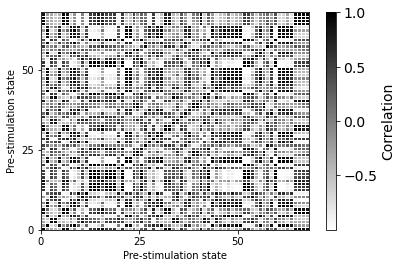

In [11]:
fig, ax = plt.subplots()
im = ax.pcolormesh(corrmat, cmap=cm.binary, edgecolors='white', linewidths=1, antialiased=True)
plt.rcParams.update({'font.size': 14})
plt.xlabel('Pre-stimulation state')
plt.ylabel('Pre-stimulation state')
plt.xticks([0,25,50])
plt.yticks([0,25,50])
#plt.title('Heatmap of Pre-stimulation Radial Profile Correlation')
fig.colorbar(im, label='Correlation')
plt.show()

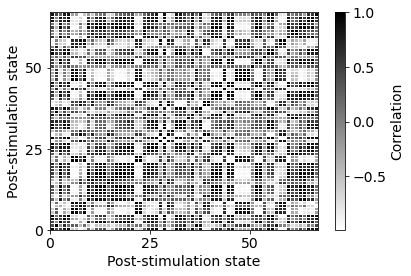

In [12]:
fig, ax = plt.subplots()
im = ax.pcolormesh(corrmat2, cmap=cm.binary, edgecolors='white', linewidths=1, antialiased=True)
fig.colorbar(im, label='Correlation')
#plt.title('Heatmap of Post-stimulation Radial Profile Correlation')
plt.xlabel('Post-stimulation state')
plt.ylabel('Post-stimulation state')
plt.xticks([0,25,50])
plt.yticks([0,25,50])
plt.show()

In [13]:
numpostcorr = 0
contdepmeans = []
contextdependent = []
for num in np.arange(n):
    corr = []
    precorr = []
    #print('Image '+str(num))
    for num2 in np.arange(num+1, n):
        if(np.corrcoef(lfpradprof[num], lfpradprof[num2])[0, 1]>0.9 and num%2==num2%2):
            #print(str(num2)+': '+str(np.corrcoef(lfpradprof[num], lfpradprof[num2])[0, 1]))
            corr.append(num2)
            if(num<134 and num2<134):
                precorr.append(np.corrcoef(lfpradprof[num+1], lfpradprof[num2+1])[0, 1])
    if(num%2==0):
        if(len(corr)==0):
            contextdependent.append(-1)
        else:
            numpostcorr = numpostcorr+1
            nprecorr = len(np.argwhere(np.asarray(precorr)>0))
            contdepmeans.append(np.mean(precorr))
            contextdependent.append(nprecorr/len(corr))

/Users/afareen/opt/anaconda3/envs/sklearn-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/afareen/opt/anaconda3/envs/sklearn-env/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [16]:
len(np.argwhere(np.asarray(contextdependent)>0.7))

22

In [17]:
#Repeat but shuffle prestates
shuffledarr = 2*np.arange(n/2).astype(int)
#Permutation
ncdpermutation = []
ncdpermmean = []
for perm in range(1000):
    np.random.shuffle(shuffledarr)
    numpostcorr = 0
    contdepmeans = []
    contextdependent = []
    for num in np.arange(n):
        corr = []
        precorr = []
        for num2 in np.arange(num+1, n):
            if(np.corrcoef(lfpradprof[num], lfpradprof[num2])[0, 1]>0.9 and num%2==num2%2):
                corr.append(num2)
                if(num>0 and num2>0 and num%2==1):
                    precorr.append(np.corrcoef(lfpradprof[shuffledarr[(int)((num-1)/2)]], lfpradprof[shuffledarr[(int)((num2-1)/2)]])[0, 1])
        if(num%2!=0):
            if(len(corr)==0):
                contextdependent.append(-1)
            else:
                numpostcorr = numpostcorr+1
                nprecorr = len(np.argwhere(np.asarray(precorr)>0))
                contdepmeans.append(np.mean(precorr))
                contextdependent.append(nprecorr/len(corr))
    #print(perm)
    ncdpermutation.append(len(np.argwhere(np.asarray(contextdependent)>0.7)))

In [18]:
print(np.mean(ncdpermutation))

14.027


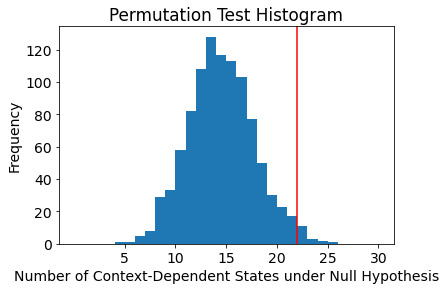

In [19]:
plt.hist(np.asarray(ncdpermutation), bins=30, range=(0,30))
plt.axvline(x=22).set_color('red')
plt.xticks([5,10,15,20,25,30])
plt.title('Permutation Test Histogram')
plt.ylabel('Frequency')
plt.xlabel('Number of Context-Dependent States under Null Hypothesis')
plt.show()

In [20]:
len(np.argwhere(np.asarray(ncdpermutation)>22))

6

In [21]:
np.std(ncdpermutation)

3.268680314744775

In [22]:
len(np.argwhere(np.asarray(ncdpermutation)>22))/len(ncdpermutation)

0.006